In [16]:
from torchvision import datasets, transforms
import torch

In [14]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])
train = datasets.MNIST('data', download=True, transform=transform)
test = datasets.MNIST('data', download=True, transform=transform, train=False)

In [38]:
# Learn Gaussian Diagonal Model
means = {}
means2 = {}
counts = {}
var = {}
for i in xrange(10):
    means[i] = torch.zeros(28*28)
    means2[i] = torch.zeros(28*28)
    counts[i] = 0
for i, (data, label) in enumerate(train):
    means[label.item()] += data.view(-1)
    means2[label.item()] += data.view(-1)**2
    counts[label.item()] += 1
for i in xrange(10):
    means[i] /= float(counts[i])
    means2[i] /= float(counts[i])
    var[i] = means2[i] - means[i]**2

In [48]:
# Learn Gaussian Full-Cov model
fullvar = {}
meanmeanT = {}
for i in xrange(10):
    meanmeanT[i] = torch.zeros((28*28, 28*28))
for i, (data, label) in enumerate(train):
    meanmeanT[label.item()] += torch.ger(data.view(-1), data.view(-1))
for i in xrange(10):
    meanmeanT[i] /= float(counts[i])
    fullvar[i] = meanmeanT[i] - torch.ger(means[i], means[i])

Text(0.5,1,'Mean')

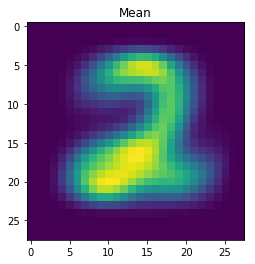

In [45]:
import matplotlib.pyplot as plt

plt.imshow(means[2].view((28, 28)).numpy())
plt.title('Mean')

Text(0.5,1,'Variance')

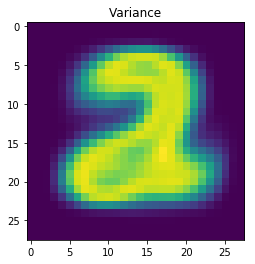

In [46]:
plt.imshow(var[2].view((28, 28)).numpy())
plt.title('Variance')

Text(0.5,1,'Variance')

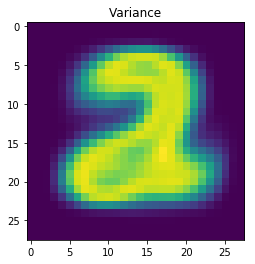

In [49]:
import numpy as np
plt.imshow(np.diag(fullvar[2].numpy()).reshape((28, 28)))
plt.title('Variance')

In [82]:
# Sample from models
import scipy.linalg
cholesky = {}
for i in xrange(10):
    eigval, eigvec = scipy.linalg.eigh(fullvar[i].numpy())
    C = eigvec.dot(np.diag(np.sqrt(np.maximum(eigval, 0))))
    cholesky[i] = torch.FloatTensor(C)

In [83]:
models = {
    'mean': means,
    'var': var,
    'fullvar': fullvar,
    'cholesky': cholesky
}
torch.save(models, 'models.pkl')

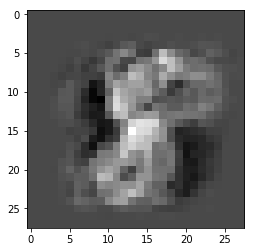

In [283]:
# Sample from full gaussian
def sample_full(digit, means, cholesky):
    z = torch.randn(len(cholesky[digit]))
    x = means[digit] + cholesky[digit].matmul(z)
    return x

sample = sample_full(8, means, cholesky)
plt.imshow(sample.view((28, 28)).numpy(), cmap='gray')

torch.Size([784])


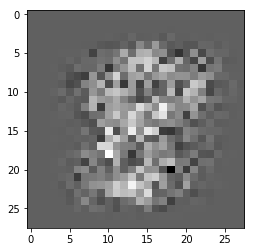

In [285]:
# Sample from diagonal gaussian
def sample_diag(digit, means, var):
    z = torch.randn(len(var[digit]))
    x = means[digit] + torch.sqrt(var[digit]) * z
    print (torch.sqrt(var[digit])).size()
    return x

sample = sample_diag(8, means, var)
plt.imshow(sample.view((28, 28)).numpy(), cmap='gray')